In [177]:
%pip install langgraph langchain-openai langchain langchain_community python-dotenv pypdf chromadb --quiet 

Note: you may need to restart the kernel to use updated packages.


In [178]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain.prompts import (
    ChatPromptTemplate,
    PromptTemplate,
    FewShotChatMessagePromptTemplate
)
from langchain.tools.render import format_tool_to_openai_tool, format_tool_to_openai_function
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI
from langchain.callbacks.manager import (
    AsyncCallbackManagerForToolRun,
    CallbackManagerForToolRun,
)
from langchain_core.tracers.context import tracing_v2_enabled
from langchain_core.tools import tool
from langchain.tools import BaseTool, StructuredTool, tool
from pydantic import Field, BaseModel
from typing import (
    Optional,
    Tuple,
    Dict,
    TypedDict,
    Type,
    Annotated,
    List,
    Union,
    Any,

)
from IPython.display import Image, display
import pandas as pd
from pydantic import BaseModel, Field
from operator import itemgetter
import os
from dotenv import load_dotenv
import json

from langchain.document_loaders import PyPDFLoader
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.chains import RetrievalQA

In [179]:
langchain_tracing = os.getenv('LANGCHAIN_TRACING_V2')
langchain_endpoint = os.getenv('LANGCHAIN_ENDPOINT')
langchain_api_key = os.getenv('LANGCHAIN_API_KEY')
openai_api_key = os.getenv('OPENAI_API_KEY')
langchain_project=os.getenv('LANGCHAIN_PROJECT')

In [180]:
gpt_3_5 = ChatOpenAI(
    openai_api_key=openai_api_key,
    model_name="gpt-3.5-turbo"
)

In [181]:
class QuickQuestionModel(BaseModel):
  """ Data Validation Layer for Quick Q&A Tool """
  query: str = Field(description="User's query/question")

  class Config:
      json_schema_extra = {
          "example": {
              "query": "How does the adoption process work in general?"
            }
        }

class ToolManagerModel(BaseModel):
  """ Data Validation Schema for Tool Manager LLM """
  query: str = Field(description="User's query/question")

  class Config:
    json_schema_extra = {
        "example": {
            "query": "I want to learn more about the adoption process."
        }
    }

class ToolParser(BaseModel):
  """
  Description:
  ------------
  This pydantic model is for custom output parser used in tool manager chain.

  Attributes:
  ------------
  tool_name: str
  """
  tool_name: str = Field(description="""
  Extract the tool name as either training, healtcare, quick question, or adoption support
  based on the request.
  """
  )

  class Config:
    json_schema_extra = {
        "example": {
            "tool_name": "quick question"
        }
    }

In [182]:
tool_manager_prompt = """"
You are a tool manager who makes decisions on which tool should be run in order to complete the requirement.

Your task is to identify the tool name based on the following request.

Identify the tools as either 'training', 'healtcare', 'quick question', or 'adoption support'.

Here the request is: {request}\n{format_instructions}

"""

quick_question_tool_prompt = """
**FOLLOW THE INSTRUCTIONS BELOW**

1 - Your task is to answer user questions with concise answers with the information provided to you.

6 - Now based on the following document and user question, answer the question in a direct way, and only give relative answers.
Information:\n{information}
Question: {question}
"""

In [183]:
class ToolManager(BaseTool):
  name = "tool_manager"
  description = "Use this tool to decide which other tool should be executed based on the given query"
  args_schema: Type[BaseModel] = ToolManagerModel

  def _run(
      self,
      request: str,
      run_manager: Optional[CallbackManagerForToolRun] = None
  ) -> str:

    """
    Description:
    -----------
    Use this tool to decide which other tool should be executed based on the given query.
    """
    tool_parser = PydanticOutputParser(pydantic_object=ToolParser)

    tool_manager_prompt_template = PromptTemplate(
        template=tool_manager_prompt,
        input_variables=["request"],
        partial_variables={"format_instructions": tool_parser.get_format_instructions()}
    )

    tool_manager_chain = (
        tool_manager_prompt_template
        | gpt_3_5
        | tool_parser
    )

    tool_name = tool_manager_chain.invoke({"request":request})
    return tool_name

In [ ]:
class QuickQuestionChain(BaseTool):
  name="quick_question"
  description="Use this tool to answer user question with the information given to you."
  args_schema: Type[BaseModel] = QuickQuestionModel

  def _run(
      self,
      query: str,
      run_manager: Optional[CallbackManagerForToolRun] = None
      ) -> str:
      """
      Description:
      -----------
      Use this tool to answer user question with the information given to you.
      """
      quick_answer_prompt_template = PromptTemplate(
        template=quick_question_tool_prompt,
        input_variables=["information", "question"]
      )
      
      quick_answer_chain = (
        quick_answer_prompt_template 
          | gpt_3_5
          | StrOutputParser()
      )

      loader = PyPDFLoader("KE - process info.pdf")
      pages = loader.load()
      
      text_splitter = CharacterTextSplitter(
          separator="\n",
          chunk_size=1000,
          chunk_overlap=150,
          length_function=len
      )
      splits = text_splitter.split_documents(pages)
      embedding = OpenAIEmbeddings()
      vectordb = Chroma.from_documents(
        documents=splits,
        embedding=embedding,
      )
      qa_chain = RetrievalQA.from_chain_type(
        gpt_3_5,
        retriever=vectordb.as_retriever()
      )

      docs = qa_chain({"query": query})

      print(docs)

      response = quick_answer_chain.invoke(
          {
            "information": docs,
            "question": query
          }
      )

      print(response)
      
      return response

In [185]:
quick_question_tool = QuickQuestionChain()
tool_manager_tool = ToolManager()

In [186]:
class GraphState(TypedDict):
  """
  Description:
  -------------
  Represents the Graph State of our Chatbot Model

  """
  question: str
  which_tool: str
  answer: str

In [187]:
def tool_manager(state):
  """
  Description:
  -------------
  Decide which tool to run

  Args:
  -----
  state (dict): The current Graph State

  Returns:
  --------
  state (dict): name of the tool
  """
  print("---TOOL MANAGER---")
  question = state["question"]

  selected_tool = tool_manager_tool._run(question)
  state["which_tool"] = selected_tool.tool_name

  return {"which_tool": selected_tool.tool_name}

In [188]:
def choose_tool(state):
  """
  Description:
  -------------
  Send the selected tool the next node

  Args:
  -----
  state (dict): The current Graph State

  Returns:
  --------
  str: name of the tool for next node to call
  """
  print("---Now Choosing A Tool---")
  which_tool = state["which_tool"]

  if which_tool == "quick question":
    print("---Running: Quick Question Tool---")
    return "quickquestion"

In [189]:
def quick_question(state):
  
  print("---QUICK QUESTION---")
  question = state["question"]

  answer = quick_question_tool._run(question)
  state["answer"] = answer

  return {"which_tool": answer}

In [190]:
workflow = StateGraph(GraphState)
workflow.add_node("tool_manager", tool_manager)
workflow.add_node("quickquestion", quick_question)

workflow.add_edge(START, "tool_manager")
workflow.add_conditional_edges(
    "tool_manager",
    choose_tool,
    {
        "quickquestion": "quickquestion",
    }
)
workflow.add_edge("quickquestion", END)

chatbot = workflow.compile()

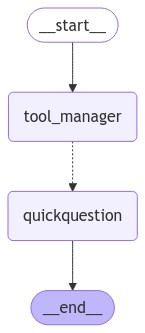

In [191]:
display(Image(chatbot.get_graph(xray=1).draw_mermaid_png()))

In [192]:
inputs = {
    "question": "Hızlı bir soru sormak istiyorum? Nasıl köpek sahiplenebilirim?",
    }
with tracing_v2_enabled(project_name="cs491_agent"):
  output = chatbot.invoke(inputs)

---TOOL MANAGER---


Created a chunk of size 1799, which is longer than the specified 1000


---Now Choosing A Tool---
---Running: Quick Question Tool---
---QUICK QUESTION---
{'query': 'Hızlı bir soru sormak istiyorum? Nasıl köpek sahiplenebilirim?', 'result': 'Maalesef hızlı bir şekilde cevap veremem çünkü köpek sahiplenme süreci detaylı bir bilgilendirme gerektirir. Köpek sahiplenmeden önce hayvanın günlük ihtiyaçları, sağlık gereksinimleri ve uyum süreçleri hakkında bilgi almanız önemlidir. Bu konuda detaylı bilgi almak ve sahiplenme şartlarını öğrenmek için bir hayvan barınağı veya kurtarma kuruluşu ile iletişime geçmenizi öneririm. Bu kuruluşlar size doğru rehberlik sağlayarak sahiplenme sürecinde size yardımcı olacaklardır.'}
Cevap: Köpek sahiplenme süreci detaylı bir bilgilendirme gerektirir. Hayvanın günlük ihtiyaçları, sağlık gereksinimleri ve uyum süreçleri hakkında bilgi almanız önemlidir. Detaylı bilgi almak ve sahiplenme şartlarını öğrenmek için bir hayvan barınağı veya kurtarma kuruluşu ile iletişime geçmenizi öneririm. Bu kuruluşlar size doğru rehberlik sağlayar